In [3]:
import pykitti
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 映射到range image

In [4]:
class LaserScan:
  """Class that contains LaserScan with x,y,z,r"""
  EXTENSIONS_SCAN = ['.bin']

  def __init__(self, project=False, H=64, W=1024, fov_up=3.0, fov_down=-25.0):
    self.project = project
    self.proj_H = H
    self.proj_W = W
    self.proj_fov_up = fov_up
    self.proj_fov_down = fov_down
    self.reset()

  def reset(self):
    """ Reset scan members. """
    self.points = np.zeros((0, 3), dtype=np.float32)        # [m, 3]: x, y, z
    self.remissions = np.zeros((0, 1), dtype=np.float32)    # [m ,1]: remission

    # projected range image - [H,W] range (-1 is no data)
    self.proj_range = np.full((self.proj_H, self.proj_W), -1,
                              dtype=np.float32)

    # unprojected range (list of depths for each point)
    self.unproj_range = np.zeros((0, 1), dtype=np.float32)

    # projected point cloud xyz - [H,W,3] xyz coord (-1 is no data)
    self.proj_xyz = np.full((self.proj_H, self.proj_W, 3), -1,
                            dtype=np.float32)

    # projected remission - [H,W] intensity (-1 is no data)
    self.proj_remission = np.full((self.proj_H, self.proj_W), -1,
                                  dtype=np.float32)

    # projected index (for each pixel, what I am in the pointcloud)
    # [H,W] index (-1 is no data)
    self.proj_idx = np.full((self.proj_H, self.proj_W), -1,
                            dtype=np.int32)

    # for each point, where it is in the range image
    self.proj_x = np.zeros((0, 1), dtype=np.int32)        # [m, 1]: x
    self.proj_y = np.zeros((0, 1), dtype=np.int32)        # [m, 1]: y

    # mask containing for each pixel, if it contains a point or not
    self.proj_mask = np.zeros((self.proj_H, self.proj_W),
                              dtype=np.int32)       # [H,W] mask

  def size(self):
    """ Return the size of the point cloud. """
    return self.points.shape[0]

  def __len__(self):
    return self.size()

  def open_scan(self, filename):
    """ Open raw scan and fill in attributes
    """
    # reset just in case there was an open structure
    self.reset()

    # check filename is string
    if not isinstance(filename, str):
      raise TypeError("Filename should be string type, "
                      "but was {type}".format(type=str(type(filename))))

    # check extension is a laserscan
    if not any(filename.endswith(ext) for ext in self.EXTENSIONS_SCAN):
      raise RuntimeError("Filename extension is not valid scan file.")

    # if all goes well, open pointcloud
    scan = np.fromfile(filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission
    self.set_points(points, remissions)

  def set_points(self, points, remissions=None):
    """ Set scan attributes (instead of opening from file)
    """
    # reset just in case there was an open structure
    self.reset()

    # check scan makes sense
    if not isinstance(points, np.ndarray):
      raise TypeError("Scan should be numpy array")

    # check remission makes sense
    if remissions is not None and not isinstance(remissions, np.ndarray):
      raise TypeError("Remissions should be numpy array")

    # put in attribute
    self.points = points    # get xyz
    if remissions is not None:
      self.remissions = remissions  # get remission
    else:
      self.remissions = np.zeros((points.shape[0]), dtype=np.float32)
class LaserScan:
  """Class that contains LaserScan with x,y,z,r"""
  EXTENSIONS_SCAN = ['.bin']

  def __init__(self, project=False, H=64, W=1024, fov_up=3.0, fov_down=-25.0):
    self.project = project
    self.proj_H = H
    self.proj_W = W
    self.proj_fov_up = fov_up
    self.proj_fov_down = fov_down
    self.reset()

  def reset(self):
    """ Reset scan members. """
    self.points = np.zeros((0, 3), dtype=np.float32)        # [m, 3]: x, y, z
    self.remissions = np.zeros((0, 1), dtype=np.float32)    # [m ,1]: remission

    # projected range image - [H,W] range (-1 is no data)
    self.proj_range = np.full((self.proj_H, self.proj_W), -1,
                              dtype=np.float32)

    # unprojected range (list of depths for each point)
    self.unproj_range = np.zeros((0, 1), dtype=np.float32)

    # projected point cloud xyz - [H,W,3] xyz coord (-1 is no data)
    self.proj_xyz = np.full((self.proj_H, self.proj_W, 3), -1,
                            dtype=np.float32)

    # projected remission - [H,W] intensity (-1 is no data)
    self.proj_remission = np.full((self.proj_H, self.proj_W), -1,
                                  dtype=np.float32)

    # projected index (for each pixel, what I am in the pointcloud)
    # [H,W] index (-1 is no data)
    self.proj_idx = np.full((self.proj_H, self.proj_W), -1,
                            dtype=np.int32)

    # for each point, where it is in the range image
    self.proj_x = np.zeros((0, 1), dtype=np.int32)        # [m, 1]: x
    self.proj_y = np.zeros((0, 1), dtype=np.int32)        # [m, 1]: y

    # mask containing for each pixel, if it contains a point or not
    self.proj_mask = np.zeros((self.proj_H, self.proj_W),
                              dtype=np.int32)       # [H,W] mask

  def size(self):
    """ Return the size of the point cloud. """
    return self.points.shape[0]

  def __len__(self):
    return self.size()

  def open_scan(self, filename):
    """ Open raw scan and fill in attributes
    """
    # reset just in case there was an open structure
    self.reset()

    # check filename is string
    if not isinstance(filename, str):
      raise TypeError("Filename should be string type, "
                      "but was {type}".format(type=str(type(filename))))

    # check extension is a laserscan
    if not any(filename.endswith(ext) for ext in self.EXTENSIONS_SCAN):
      raise RuntimeError("Filename extension is not valid scan file.")

    # if all goes well, open pointcloud
    scan = np.fromfile(filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission
    self.set_points(points, remissions)

  def set_points(self, points, remissions=None):
    """ Set scan attributes (instead of opening from file)
    """
    # reset just in case there was an open structure
    self.reset()

    # check scan makes sense
    if not isinstance(points, np.ndarray):
      raise TypeError("Scan should be numpy array")

    # check remission makes sense
    if remissions is not None and not isinstance(remissions, np.ndarray):
      raise TypeError("Remissions should be numpy array")

    # put in attribute
    self.points = points    # get xyz
    if remissions is not None:
      self.remissions = remissions  # get remission
    else:
      self.remissions = np.zeros((points.shape[0]), dtype=np.float32)

    # if projection is wanted, then do it and fill in the structure
    if self.project:
      self.do_range_projection()

  def do_range_projection(self):
    """ Project a pointcloud into a spherical projection image.projection.
        Function takes no arguments because it can be also called externally
        if the value of the constructor was not set (in case you change your
        mind about wanting the projection)
    """
    # laser parameters
    fov_up = self.proj_fov_up / 180.0 * np.pi      # field of view up in rad
    fov_down = self.proj_fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad

    # get depth of all points
    depth = np.linalg.norm(self.points, 2, axis=1)

    # get scan components
    scan_x = self.points[:, 0]
    scan_y = self.points[:, 1]
    scan_z = self.points[:, 2]

    # get angles of all points
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)

    # get projections in image coords
    proj_x = 0.5 * (yaw / np.pi + 1.0)          # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov        # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= self.proj_W                              # in [0.0, W]
    proj_y *= self.proj_H                              # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(self.proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)   # in [0,W-1]
    self.proj_x = np.copy(proj_x)  # store a copy in orig order

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(self.proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)   # in [0,H-1]
    self.proj_y = np.copy(proj_y)  # stope a copy in original order

    # copy of depth in original order
    self.unproj_range = np.copy(depth)

    # order in decreasing depth
    indices = np.arange(depth.shape[0])
    order = np.argsort(depth)[::-1]
    depth = depth[order]
    indices = indices[order]
    points = self.points[order]
    remission = self.remissions[order]
    proj_y = proj_y[order]
    proj_x = proj_x[order]

    # assing to images
    self.proj_range[proj_y, proj_x] = depth
    self.proj_xyz[proj_y, proj_x] = points
    self.proj_remission[proj_y, proj_x] = remission
    self.proj_idx[proj_y, proj_x] = indices
    self.proj_mask = (self.proj_idx > 0).astype(np.int32)
    # if projection is wanted, then do it and fill in the structure
    if self.project:
      self.do_range_projection()

  def do_range_projection(self):
    """ Project a pointcloud into a spherical projection image.projection.
        Function takes no arguments because it can be also called externally
        if the value of the constructor was not set (in case you change your
        mind about wanting the projection)
    """
    # laser parameters
    fov_up = self.proj_fov_up / 180.0 * np.pi      # field of view up in rad
    fov_down = self.proj_fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad

    # get depth of all points
    depth = np.linalg.norm(self.points, 2, axis=1)

    # get scan components
    scan_x = self.points[:, 0]
    scan_y = self.points[:, 1]
    scan_z = self.points[:, 2]

    # get angles of all points
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)

    # get projections in image coords
    proj_x = 0.5 * (yaw / np.pi + 1.0)          # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov        # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= self.proj_W                              # in [0.0, W]
    proj_y *= self.proj_H                              # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(self.proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)   # in [0,W-1]
    self.proj_x = np.copy(proj_x)  # store a copy in orig order

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(self.proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)   # in [0,H-1]
    self.proj_y = np.copy(proj_y)  # stope a copy in original order

    # copy of depth in original order
    self.unproj_range = np.copy(depth)

    # order in decreasing depth
    indices = np.arange(depth.shape[0])
    order = np.argsort(depth)[::-1]
    depth = depth[order]
    indices = indices[order]
    points = self.points[order]
    remission = self.remissions[order]
    proj_y = proj_y[order]
    proj_x = proj_x[order]

    # assing to images
    self.proj_range[proj_y, proj_x] = depth
    self.proj_xyz[proj_y, proj_x] = points
    self.proj_remission[proj_y, proj_x] = remission
    self.proj_idx[proj_y, proj_x] = indices
    self.proj_mask = (self.proj_idx > 0).astype(np.int32)

In [5]:
basedir = '../datasets'
date = '2011_10_03'
drive = '0027'
dataset = pykitti.raw(basedir, date, drive)
data = dataset.get_velo(0)

laserscan = LaserScan(project=True)
# 填充点云数据
points = data[:, :3]  # x, y, z
remissions = data[:, 3]  # 反射率
laserscan.set_points(points, remissions)
# 执行范围投影
laserscan.do_range_projection()
# 访问投影结果
range_image = laserscan.proj_range
xyz_image = laserscan.proj_xyz
remission_image = laserscan.proj_remission


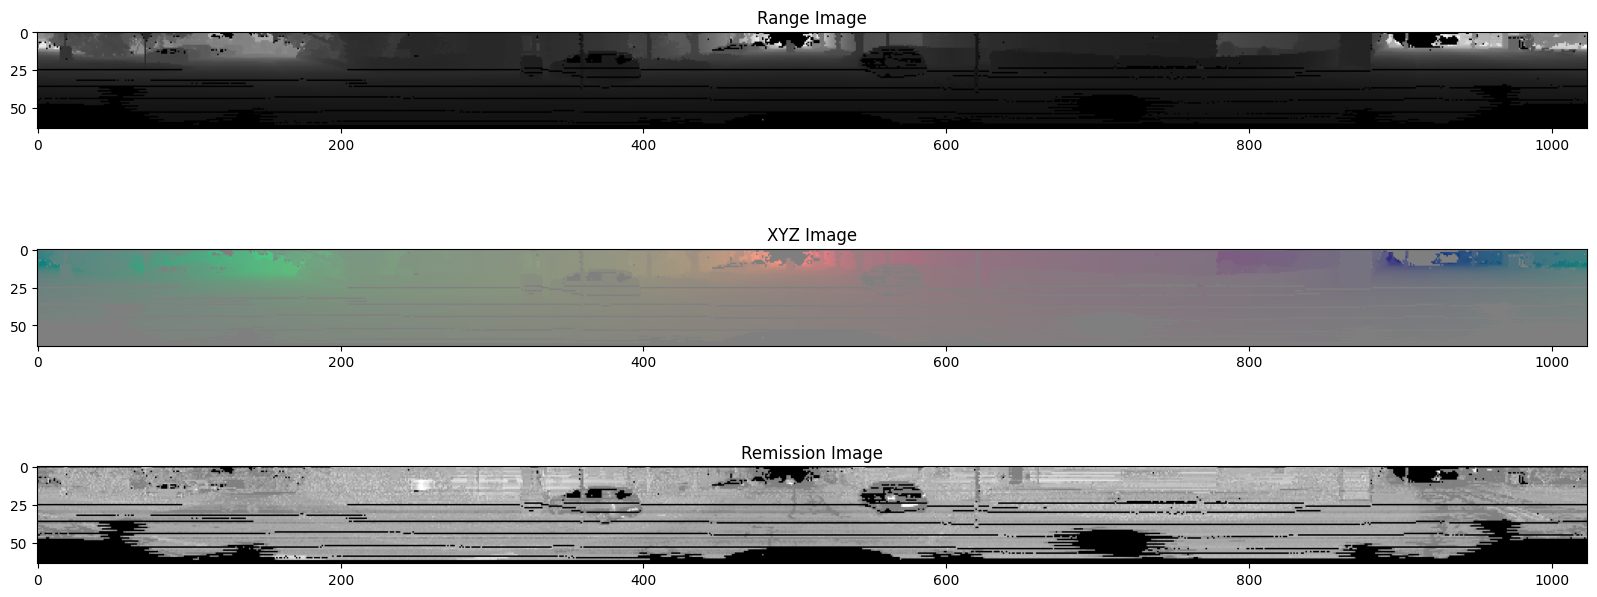

In [12]:
import matplotlib.pyplot as plt

# 设置图像大小
plt.figure(figsize=(20, 8))

# 可视化范围图像
plt.subplot(3, 1, 1)  # 三行一列，位置为1
plt.imshow(range_image, cmap='gray')
plt.title('Range Image')

# 可视化XYZ坐标图像
# 注意：XYZ图像需要一定的处理才能显色，以下仅为示例
xyz_norm = (xyz_image - xyz_image.min()) / (xyz_image.max() - xyz_image.min())
plt.subplot(3, 1, 2)  # 三行一列，位置为2
plt.imshow(xyz_norm)
plt.title('XYZ Image')


# 可视化反射率图像
plt.subplot(3, 1, 3)  # 三行一列，位置为3
plt.imshow(remission_image, cmap='gray')
plt.title('Remission Image')


plt.show()
